# MVBS from multiple raw data files

Compare MVBS calculation based on index (using `coarsen`) and based on time (`resample` + `groupby_bins`). Here the resample interval is `'1H'` so the wait time is reasonable with 5 files open simultaneously.

In [1]:
import os
import glob
import xarray as xr

In [2]:
import time

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from dask.distributed import Client
client = Client()

In [5]:
from dask.distributed import performance_report

## Load multiple data files

In [6]:
nc_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_raw/'
nc_files = sorted(glob.glob(nc_path+'*.nc'))   # sort to order by date in filename
nc_Sv_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_Sv/'
nc_Sv_files = sorted(glob.glob(nc_Sv_path+'*_Sv.nc'))   # sort to order by date in filename

In [7]:
# Load 5 files so wait time is manageable
ds_mf_chunk = xr.open_mfdataset(nc_Sv_files[:5], combine='by_coords').chunk({'ping_time': 4000})
ds_mf_chunk

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 143564, range_bin: 1046)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-21T23:19:59.682000
Data variables:
    Sv         (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 4000, 1046), meta=np.ndarray>
    range      (ping_time, frequency, range_bin) float64 dask.array<chunksize=(4000, 3, 1046), meta=np.ndarray>

In [8]:
ds_mf_chunk.chunks

Frozen(SortedKeysDict({'frequency': (3,), 'ping_time': (4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 3564), 'range_bin': (1046,)}))

In [9]:
ds_mf_chunk.Sv.data

,Array,Chunk
Bytes,3.60 GB,100.42 MB
Shape,"(3, 143564, 1046)","(3, 4000, 1046)"
Count,96 Tasks,36 Chunks
Type,float64,numpy.ndarray


## Get various variables for MVBS calculation

Calculating sample thickness, which will be used to determine the number of range bins used for each MVBS tile.

In [10]:
with xr.open_dataset(nc_files[0], group="Beam") as ds_beam:
    with xr.open_dataset(nc_files[0], group="Environment") as ds_env:
        sample_thickness = ds_env.sound_speed_indicative * ds_beam.sample_interval / 2  # sample thickness
sample_thickness

<xarray.DataArray (frequency: 3)>
array([0.19121777, 0.19121777, 0.19121777], dtype=float32)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0

Set range bin (depth) and ping number sizes for each MVBS tile.

In [11]:
MVBS_range_bin_size = 5  # [m]
MVBS_ping_size = 40      # ping number

Adjust tile range bin size so that it is an integer multiple of the sample thickness.

In [12]:
# Adjust noise_est_range_bin_size because range_bin_size may be an inconvenient value
r_data_sz = ds_mf_chunk['range_bin'].size   # dimension of range_bin in data file
num_r_per_tile = (np.round(MVBS_range_bin_size / sample_thickness).
                  astype(int)).values.max()  # num of range_bin per tile
MVBS_range_bin_size = (num_r_per_tile * sample_thickness).values

num_tile_range_bin = np.ceil(r_data_sz / num_r_per_tile).astype(int)

print(f'There are {num_r_per_tile} range bins in each MVBS tile.')
print(f'There are a total of {num_tile_range_bin} range_bin bins for each Sv tile.')

There are 26 range bins in each MVBS tile.
There are a total of 41 range_bin bins for each Sv tile.


Below are the bin edges we will use to group values along the `range_bin` dimension:

In [13]:
r_tile_bin_edge = np.arange(num_tile_range_bin+1) * num_r_per_tile - 1
r_tile_bin_edge

array([  -1,   25,   51,   77,  103,  129,  155,  181,  207,  233,  259,
        285,  311,  337,  363,  389,  415,  441,  467,  493,  519,  545,
        571,  597,  623,  649,  675,  701,  727,  753,  779,  805,  831,
        857,  883,  909,  935,  961,  987, 1013, 1039, 1065])

## MVBS computation

In the original code we needed to add one more coordinate variable `add_idx` in order to use `groupby` to calculate averages along the `ping_time` dimension. We also needed to do explicit `groupby_bins` operation to calculate averages along the `range_bin` dimension. 

Now with the `coarsen` function -- which was designed to perform multi-dimensional block-wise computations -- we don't need to do these explicitly, IF the average along `ping_time` is based on index. If the average along `ping_time` is based on the time itself, we can then use `resample` to perform the average first along `ping_time` and then use `groupby_bins` along `range_bin`.

### Based on index along `ping_time`

In the above we also chunked the loaded Sv data into blocks of 4000, which would work well if the MVBS cell size along `ping_time` is 40. 

One thing we should try in echopype is to change the chunk size according to the specified desired MVBS cell size right before computing MVBS to see if it makes the computation more efficient.

In [14]:
ds_mf_chunk_linear = 10**(ds_mf_chunk/10)  # convert to linear domain
ds_mf_chunk_linear

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 143564, range_bin: 1046)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-21T23:19:59.682000
Data variables:
    Sv         (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 4000, 1046), meta=np.ndarray>
    range      (ping_time, frequency, range_bin) float64 dask.array<chunksize=(4000, 3, 1046), meta=np.ndarray>

In [15]:
MVBS_coarsen_chunk = 10*np.log10(    # convert back to log domain
    ds_mf_chunk_linear.coarsen(ping_time=120, 
                               range_bin=num_r_per_tile, 
                               boundary='pad').mean())
MVBS_coarsen_chunk

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 1197, range_bin: 41)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) float64 12.5 38.5 64.5 ... 1e+03 1.026e+03 1.042e+03
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:01:00.784849999 ... 2015-08-21T23:19:38.115840909
Data variables:
    Sv         (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 33, 40), meta=np.ndarray>
    range      (ping_time, frequency, range_bin) float64 dask.array<chunksize=(33, 3, 40), meta=np.ndarray>

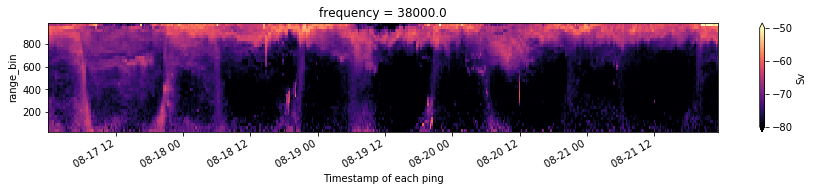

In [16]:
fig, ax = plt.subplots(figsize=(15,2))
MVBS_coarsen_chunk['Sv'].sel(frequency=38000).isel(range_bin=slice(1,38)).\
    plot(ax=ax, x='ping_time',cmap='magma',vmin=-80,vmax=-50)
plt.show()

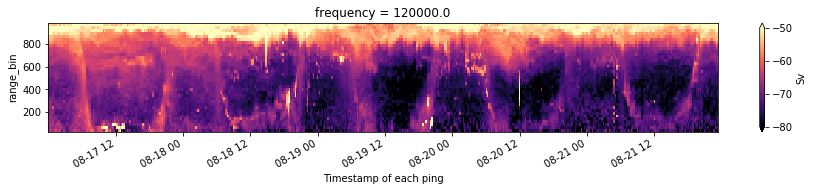

In [17]:
fig, ax = plt.subplots(figsize=(15,2))
MVBS_coarsen_chunk['Sv'].sel(frequency=120000).isel(range_bin=slice(1,38)).\
    plot(ax=ax, x='ping_time',cmap='magma',vmin=-80,vmax=-50)
plt.show()

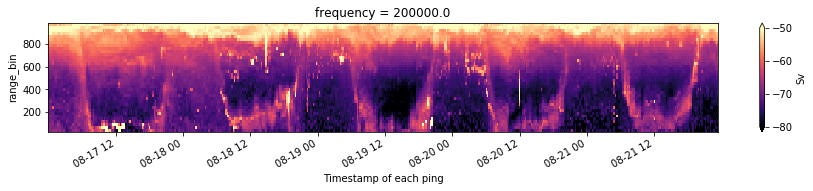

In [18]:
fig, ax = plt.subplots(figsize=(15,2))
MVBS_coarsen_chunk['Sv'].sel(frequency=200000).isel(range_bin=slice(1,38)).\
    plot(ax=ax, x='ping_time',cmap='magma',vmin=-80,vmax=-50)
plt.show()

### Based on time along ping_time

The coarsen operation can only be based on index, so to compute MVBS based on the actual timestamp, we will need to combined `resample` and `groupby_bins` along the `ping_time` and `range_bin` dimensions, respectively.

Let's do this by trying to produce MVBS with a cell size of 20 min x ~5 m.

In [19]:
MVBS_time_chunk_linear = ds_mf_chunk_linear.resample(ping_time='1H').mean()
MVBS_time_chunk_linear

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 120, range_bin: 1046)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-08-21T23:00:00
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
Data variables:
    Sv         (ping_time, frequency, range_bin) float64 dask.array<chunksize=(1, 3, 1046), meta=np.ndarray>
    range      (ping_time, frequency, range_bin) float64 dask.array<chunksize=(1, 3, 1046), meta=np.ndarray>

Let's check the ping time to make sure results of the resampling operation makes sens:

In [20]:
MVBS_time_chunk_linear['ping_time']

<xarray.DataArray 'ping_time' (ping_time: 120)>
array(['2015-08-17T00:00:00.000000000', '2015-08-17T01:00:00.000000000',
       '2015-08-17T02:00:00.000000000', '2015-08-17T03:00:00.000000000',
       '2015-08-17T04:00:00.000000000', '2015-08-17T05:00:00.000000000',
       '2015-08-17T06:00:00.000000000', '2015-08-17T07:00:00.000000000',
       '2015-08-17T08:00:00.000000000', '2015-08-17T09:00:00.000000000',
       '2015-08-17T10:00:00.000000000', '2015-08-17T11:00:00.000000000',
       '2015-08-17T12:00:00.000000000', '2015-08-17T13:00:00.000000000',
       '2015-08-17T14:00:00.000000000', '2015-08-17T15:00:00.000000000',
       '2015-08-17T16:00:00.000000000', '2015-08-17T17:00:00.000000000',
       '2015-08-17T18:00:00.000000000', '2015-08-17T19:00:00.000000000',
       '2015-08-17T20:00:00.000000000', '2015-08-17T21:00:00.000000000',
       '2015-08-17T22:00:00.000000000', '2015-08-17T23:00:00.000000000',
       '2015-08-18T00:00:00.000000000', '2015-08-18T01:00:00.000000000',
   

In [21]:
MVBS_time_range_chunk = 10*np.log10(  # convert back to log domain
    MVBS_time_chunk_linear.groupby_bins('range_bin',r_tile_bin_edge).mean())
MVBS_time_range_chunk

<xarray.Dataset>
Dimensions:         (frequency: 3, ping_time: 120, range_bin_bins: 41)
Coordinates:
  * frequency       (frequency) float32 120000.0 38000.0 200000.0
  * range_bin_bins  (range_bin_bins) object (-1, 25] (25, 51] ... (1039, 1065]
  * ping_time       (ping_time) datetime64[ns] 2015-08-17 ... 2015-08-21T23:00:00
Data variables:
    Sv              (range_bin_bins, ping_time, frequency) float64 dask.array<chunksize=(1, 1, 3), meta=np.ndarray>
    range           (range_bin_bins, ping_time, frequency) float64 dask.array<chunksize=(1, 1, 3), meta=np.ndarray>

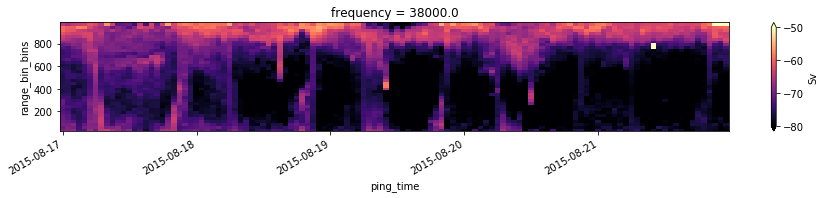

In [22]:
fig, ax = plt.subplots(figsize=(15,2))
MVBS_time_range_chunk['Sv'].sel(frequency=38000).isel(range_bin_bins=slice(1,38)).\
    plot(ax=ax, x='ping_time',cmap='magma',vmin=-80,vmax=-50)
plt.show()

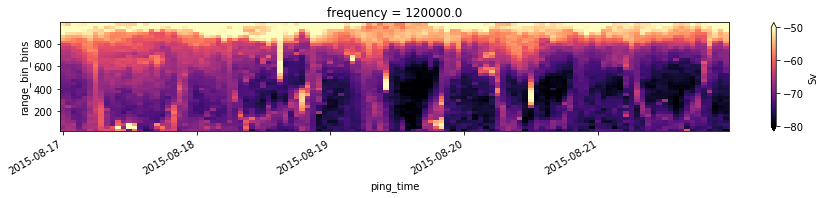

In [23]:
fig, ax = plt.subplots(figsize=(15,2))
MVBS_time_range_chunk['Sv'].sel(frequency=120000).isel(range_bin_bins=slice(1,38)).\
    plot(ax=ax, x='ping_time',cmap='magma',vmin=-80,vmax=-50)
plt.show()

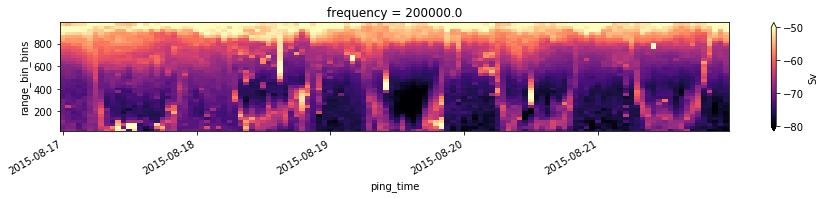

In [24]:
fig, ax = plt.subplots(figsize=(15,2))
MVBS_time_range_chunk['Sv'].sel(frequency=200000).isel(range_bin_bins=slice(1,38)).\
    plot(ax=ax, x='ping_time',cmap='magma',vmin=-80,vmax=-50)
plt.show()